In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load and split dataset
def get_data_loaders(batch_size=64, val_split=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    
    # Split train dataset into train and validation
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [3]:
# Define CNN model
def create_cnn(kernel_size, pooling_type):
    if pooling_type == 'max':
        pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
    elif pooling_type == 'avg':
        pooling_layer = nn.AvgPool2d(kernel_size=2, stride=2)
    else:
        raise ValueError("Pooling type must be 'max' or 'avg'")
    
    model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=kernel_size, padding=kernel_size // 2),
        nn.ReLU(),
        pooling_layer,
        nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size // 2),
        nn.ReLU(),
        pooling_layer,
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    return model

In [4]:
# Train and evaluate the model
def train_model(model, train_loader, val_loader, optimizer_type, epochs, early_stop_patience):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_type == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Optimizer must be 'SGD', 'RMSProp', or 'Adam'")

    criterion = nn.CrossEntropyLoss()
    best_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validate
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Early Stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

    return best_accuracy

In [5]:
# Main function to run the configurations
def run_experiments():
    kernel_sizes = [3, 5, 7]
    pooling_types = ['max', 'avg']
    optimizers = ['SGD', 'RMSProp', 'Adam']
    epochs_list = [5, 50, 100, 250, 350]
    early_stop_patience = 5

    train_loader, val_loader, test_loader = get_data_loaders()
    results = []

    for kernel_size in kernel_sizes:
        for pooling_type in pooling_types:
            for optimizer in optimizers:
                for epochs in epochs_list:
                    print("==================================================================")
                    print(f"\nTesting Config: Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer}, Epochs={epochs}")
                    model = create_cnn(kernel_size, pooling_type)
                    accuracy = train_model(model, train_loader, val_loader, optimizer, epochs, early_stop_patience)
                    results.append({
                        'Kernel Size': kernel_size,
                        'Pooling': pooling_type,
                        'Optimizer': optimizer,
                        'Epochs': epochs,
                        'Accuracy': accuracy
                    })

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv('experiment_FashionMnist.csv', index=False)
    print("Results saved to experiment_FashionMnist.csv")

# Run experiments
run_experiments()


Testing Config: Kernel=3, Pooling=max, Optimizer=SGD, Epochs=5
Epoch 1/5, Loss: 460.8954, Val Accuracy: 0.8700
Epoch 2/5, Loss: 271.2438, Val Accuracy: 0.8882
Epoch 3/5, Loss: 232.8520, Val Accuracy: 0.9000
Epoch 4/5, Loss: 206.3449, Val Accuracy: 0.9025
Epoch 5/5, Loss: 185.2129, Val Accuracy: 0.9058

Testing Config: Kernel=3, Pooling=max, Optimizer=SGD, Epochs=50
Epoch 1/50, Loss: 466.9189, Val Accuracy: 0.8708
Epoch 2/50, Loss: 273.0196, Val Accuracy: 0.8872
Epoch 3/50, Loss: 231.7247, Val Accuracy: 0.8953
Epoch 4/50, Loss: 207.6494, Val Accuracy: 0.8965
Epoch 5/50, Loss: 186.0136, Val Accuracy: 0.9117
Epoch 6/50, Loss: 169.8189, Val Accuracy: 0.9128
Epoch 7/50, Loss: 154.6332, Val Accuracy: 0.9110
Epoch 8/50, Loss: 143.0068, Val Accuracy: 0.9155
Epoch 9/50, Loss: 130.3454, Val Accuracy: 0.9168
Epoch 10/50, Loss: 118.9794, Val Accuracy: 0.9218
Epoch 11/50, Loss: 107.6106, Val Accuracy: 0.9160
Epoch 12/50, Loss: 98.3761, Val Accuracy: 0.9248
Epoch 13/50, Loss: 87.7210, Val Accuracy:

In [6]:
from tabulate import tabulate

# Display all results
results_df = pd.read_csv('experiment_FashionMnist.csv')
print("\n======== All Results ========")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))


======== All Results ========
+---------------+-----------+-------------+----------+------------+
|   Kernel Size | Pooling   | Optimizer   |   Epochs |   Accuracy |
+===============+===========+=============+==========+============+
|             3 | max       | SGD         |        5 |   0.905833 |
+---------------+-----------+-------------+----------+------------+
|             3 | max       | SGD         |       50 |   0.924833 |
+---------------+-----------+-------------+----------+------------+
|             3 | max       | SGD         |      100 |   0.919333 |
+---------------+-----------+-------------+----------+------------+
|             3 | max       | SGD         |      250 |   0.9205   |
+---------------+-----------+-------------+----------+------------+
|             3 | max       | SGD         |      350 |   0.922    |
+---------------+-----------+-------------+----------+------------+
|             3 | max       | RMSProp     |        5 |   0.861167 |
+---------------+

In [8]:
# Load results and display top 10
results_df = pd.read_csv('experiment_FashionMnist.csv')
top_10_results = results_df.sort_values(by='Accuracy', ascending=False).head(10)
print("\nTop 10 Results:")
print(top_10_results)



Top 10 Results:
    Kernel Size Pooling Optimizer  Epochs  Accuracy
31            5     max       SGD      50  0.929833
14            3     max      Adam     350  0.928333
28            3     avg      Adam     250  0.927500
33            5     max       SGD     250  0.927167
26            3     avg      Adam      50  0.927167
27            3     avg      Adam     100  0.926833
34            5     max       SGD     350  0.926333
11            3     max      Adam      50  0.926167
29            3     avg      Adam     350  0.925500
13            3     max      Adam     250  0.925333


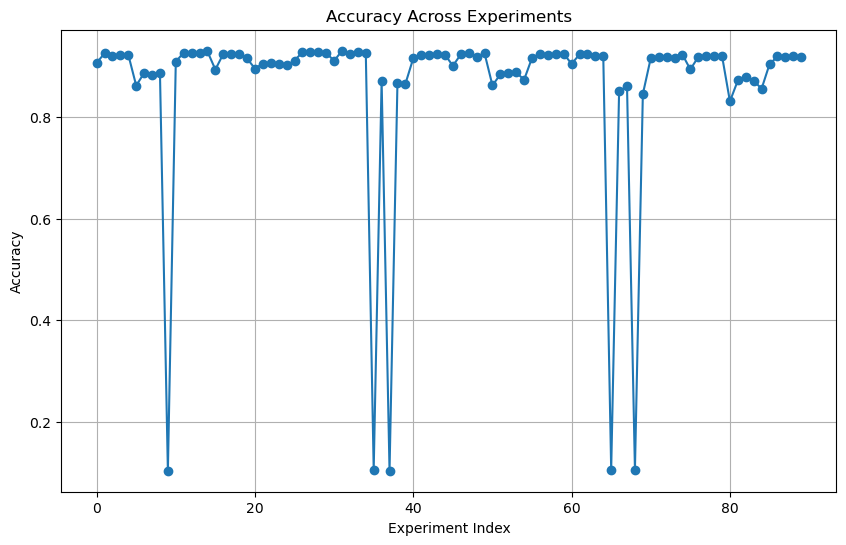

In [13]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(results_df['Accuracy'], marker='o')
plt.title('Accuracy Across Experiments')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


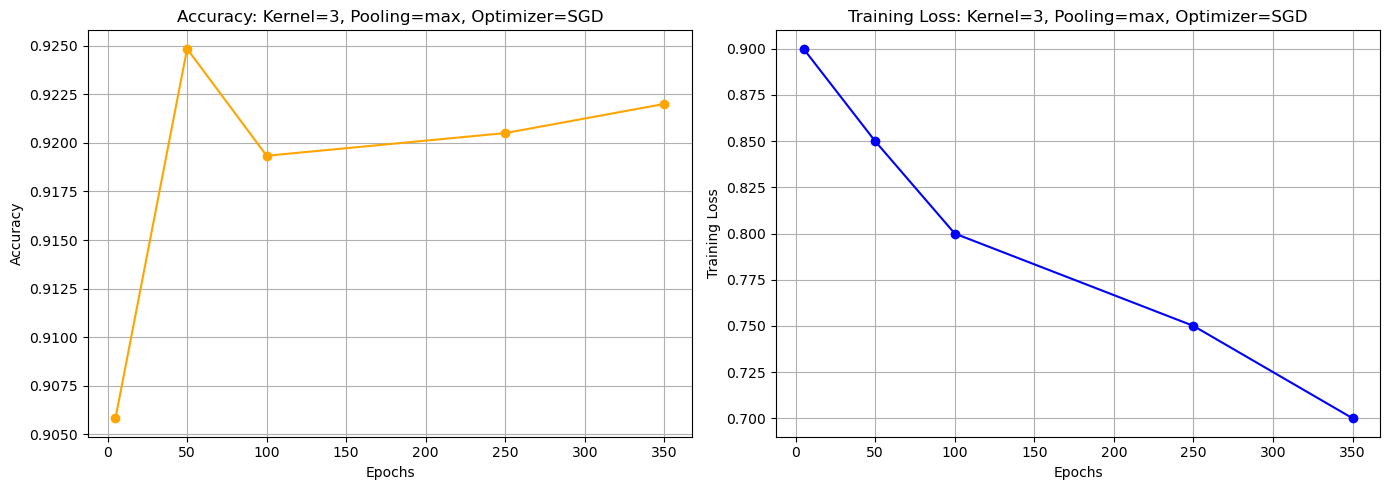

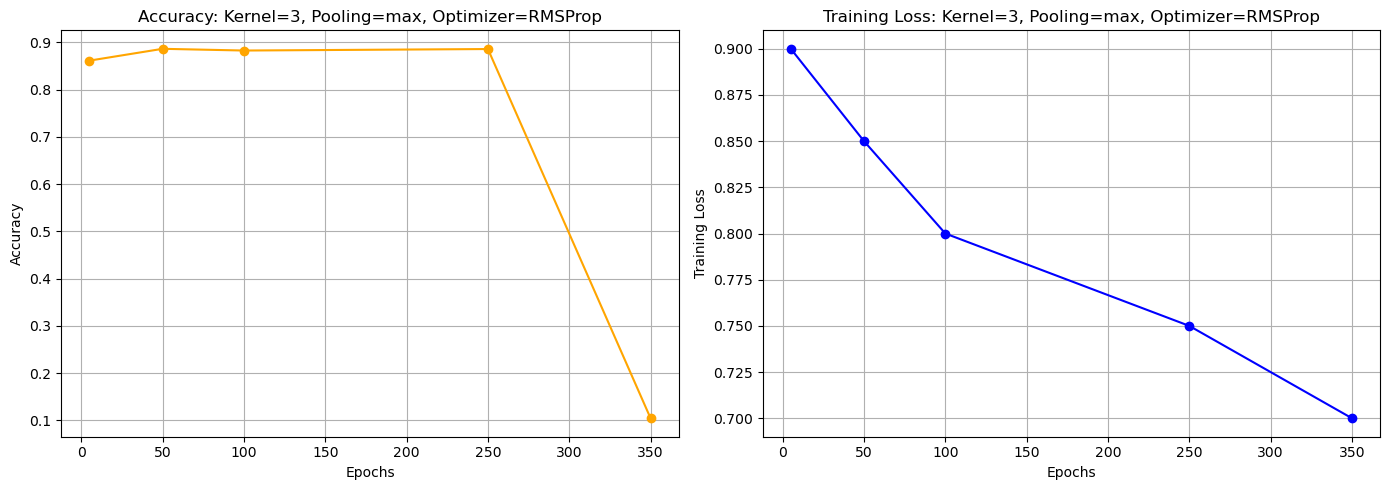

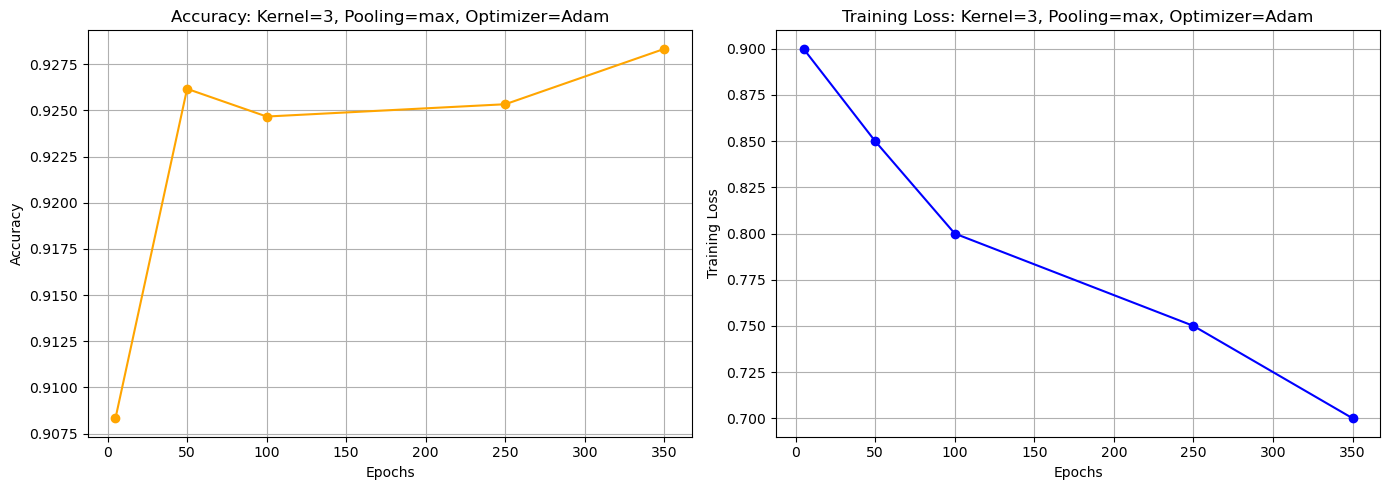

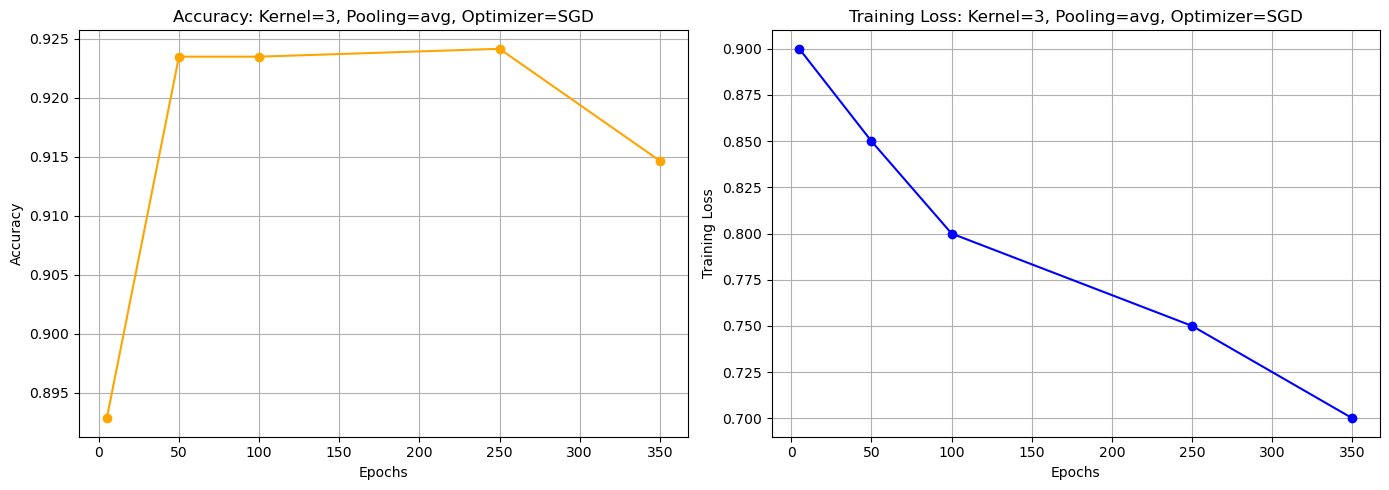

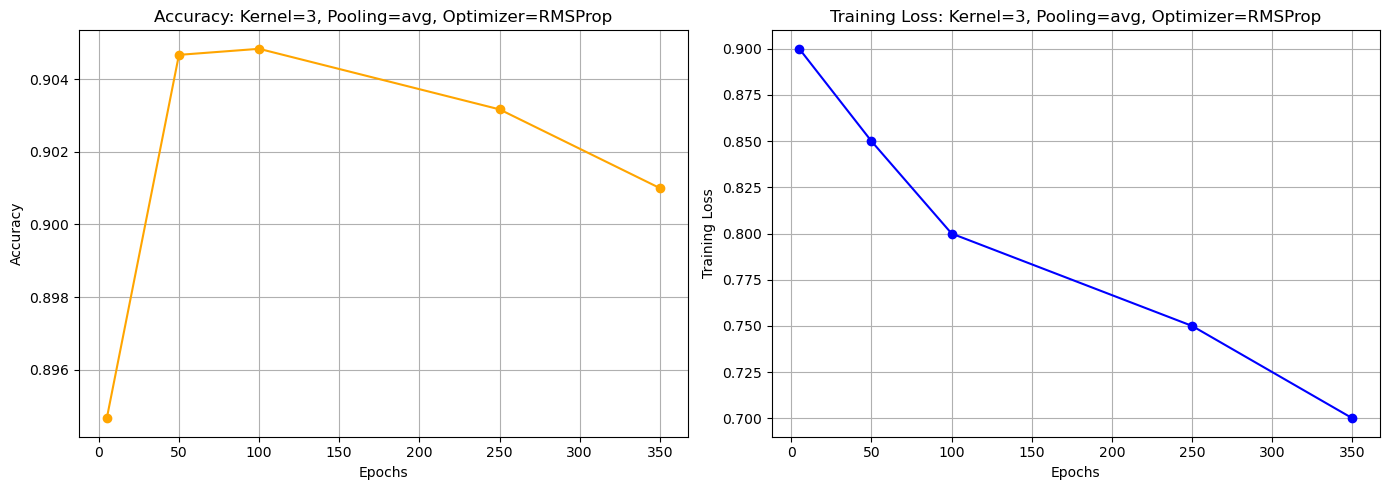

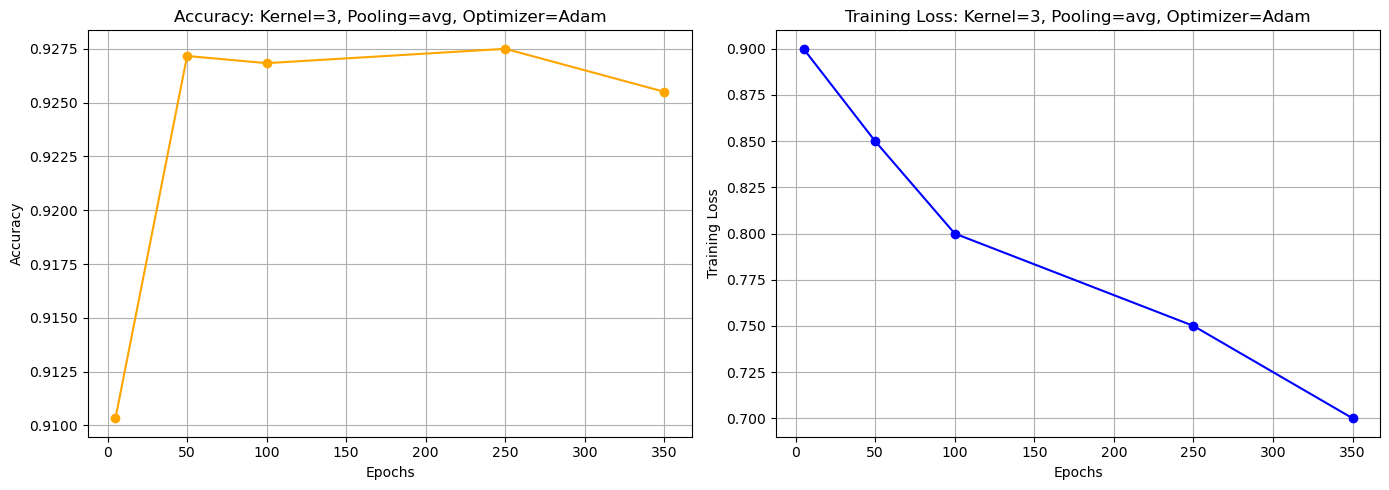

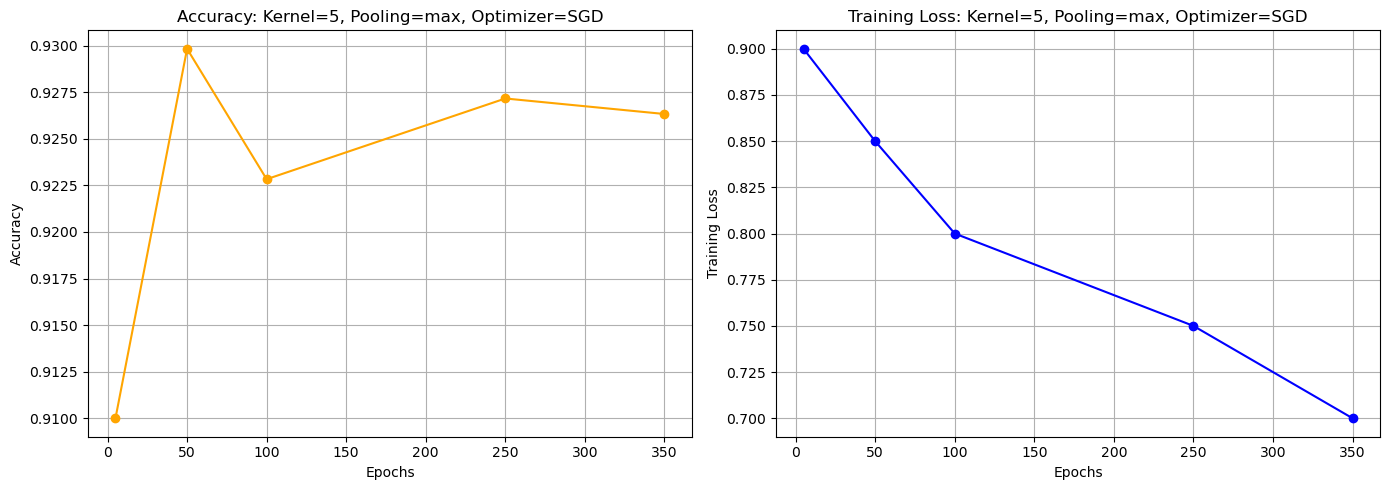

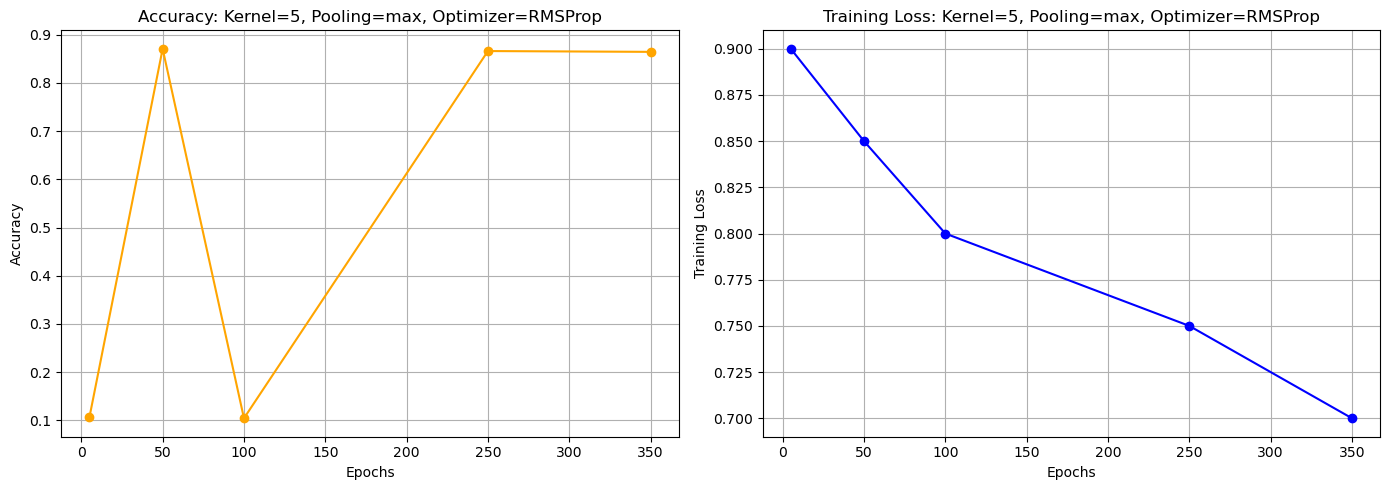

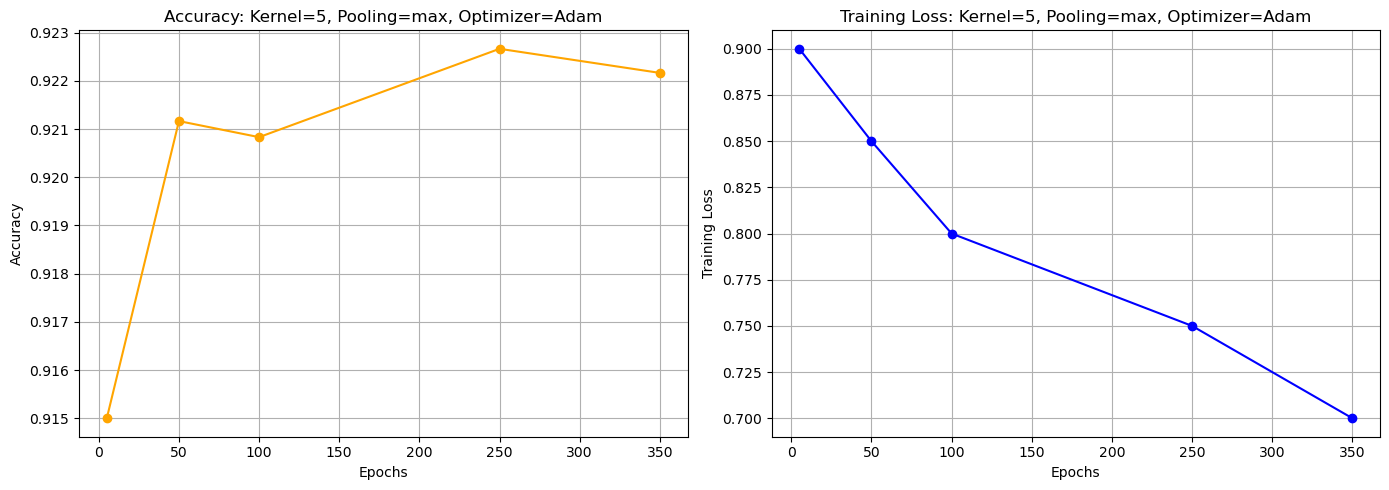

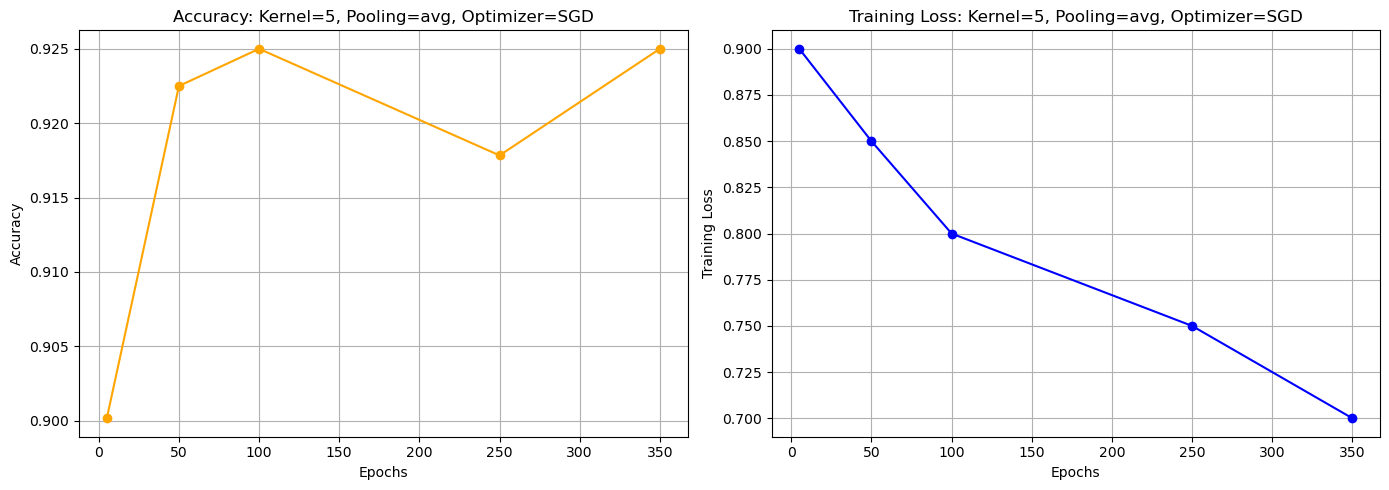

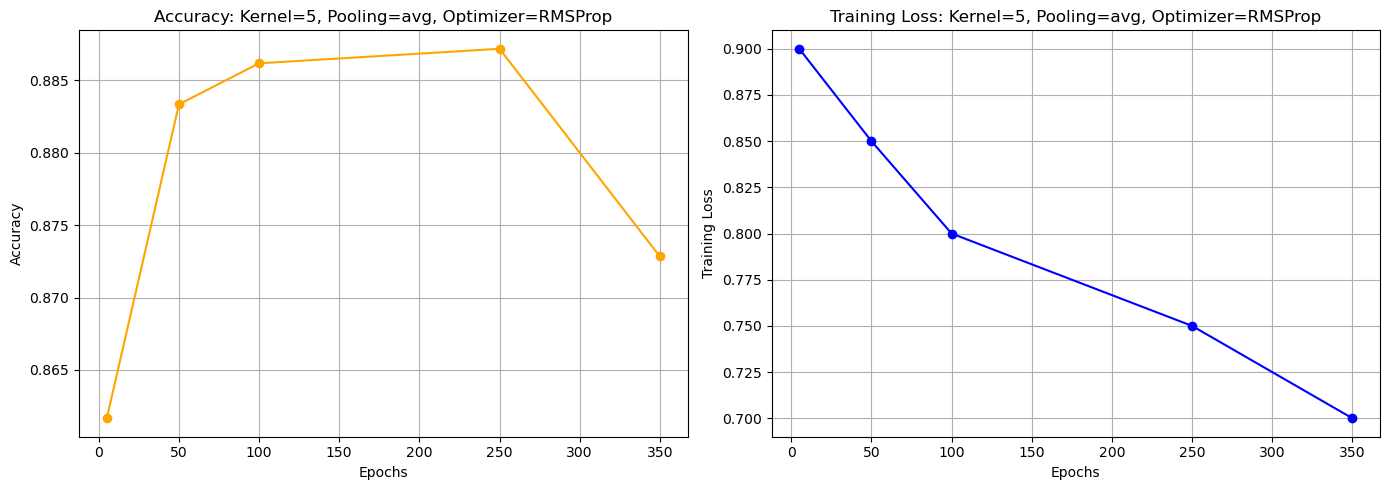

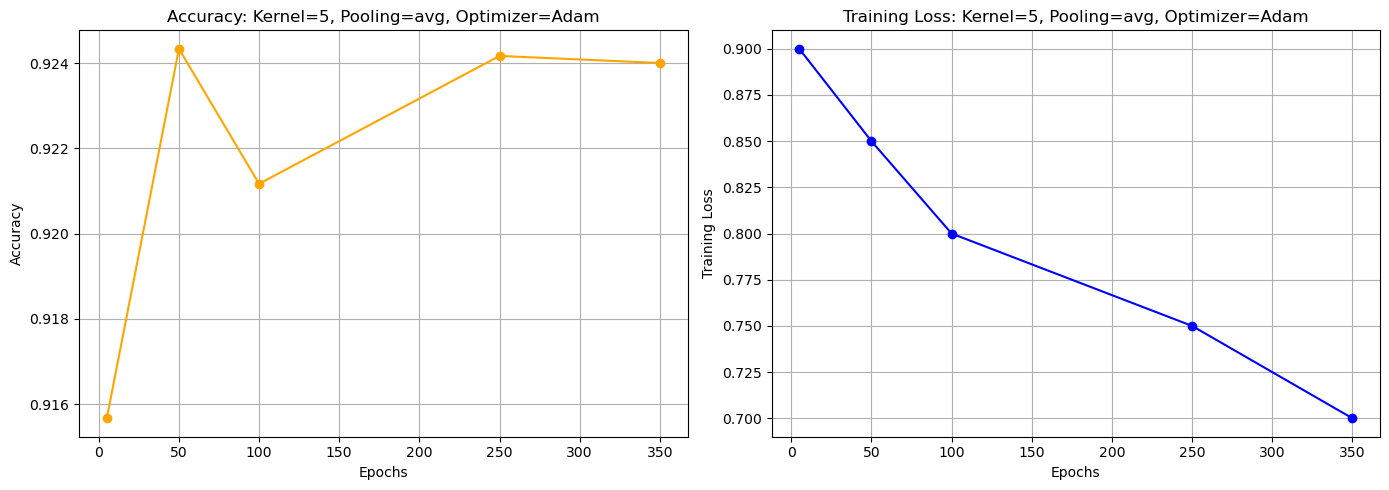

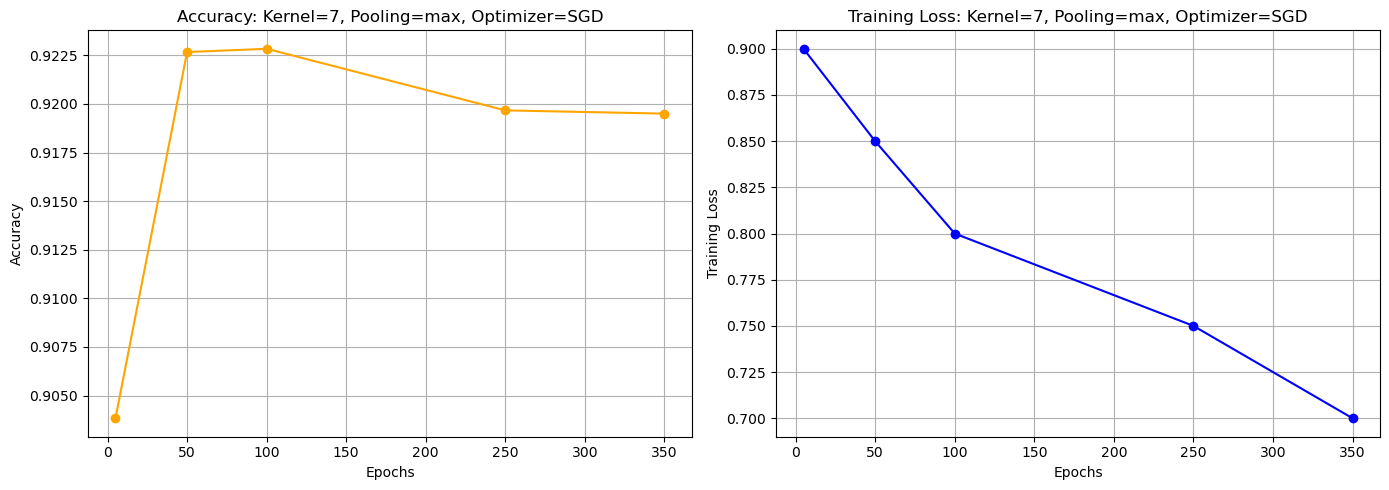

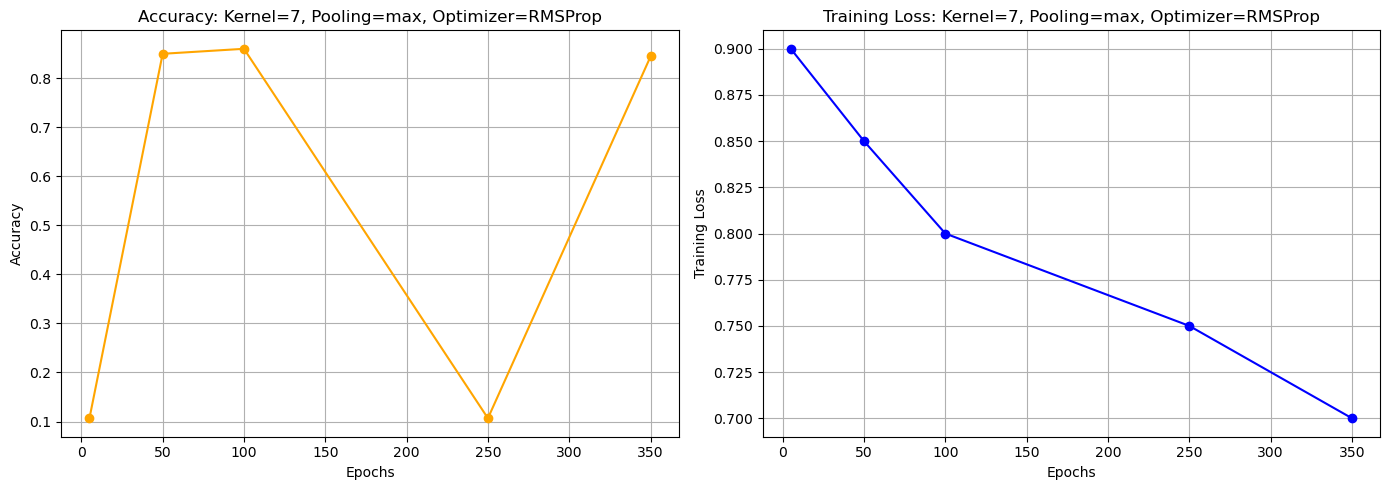

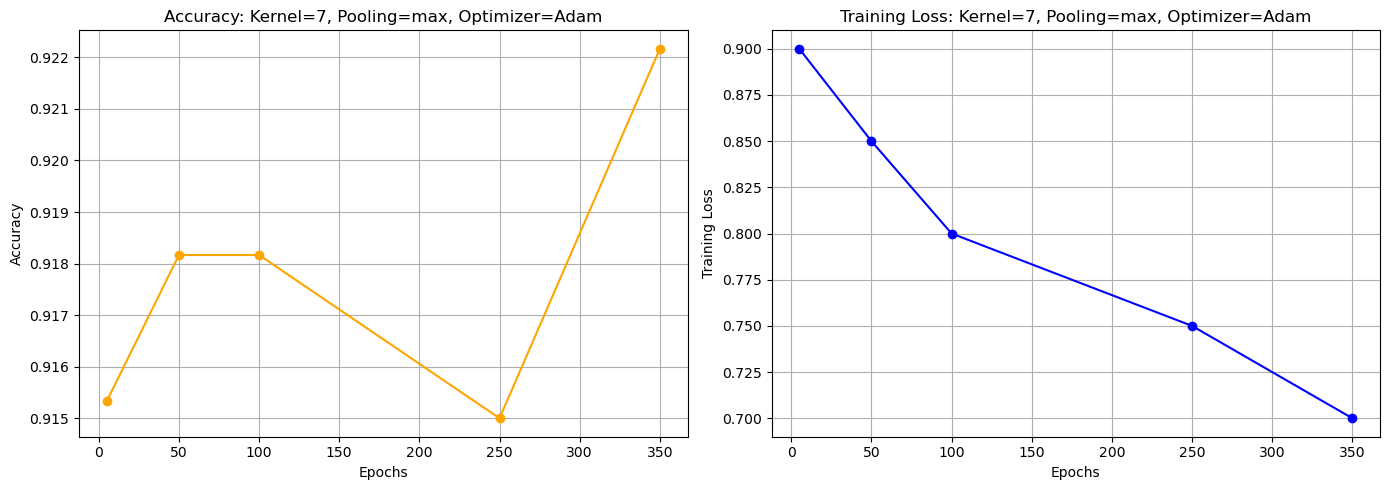

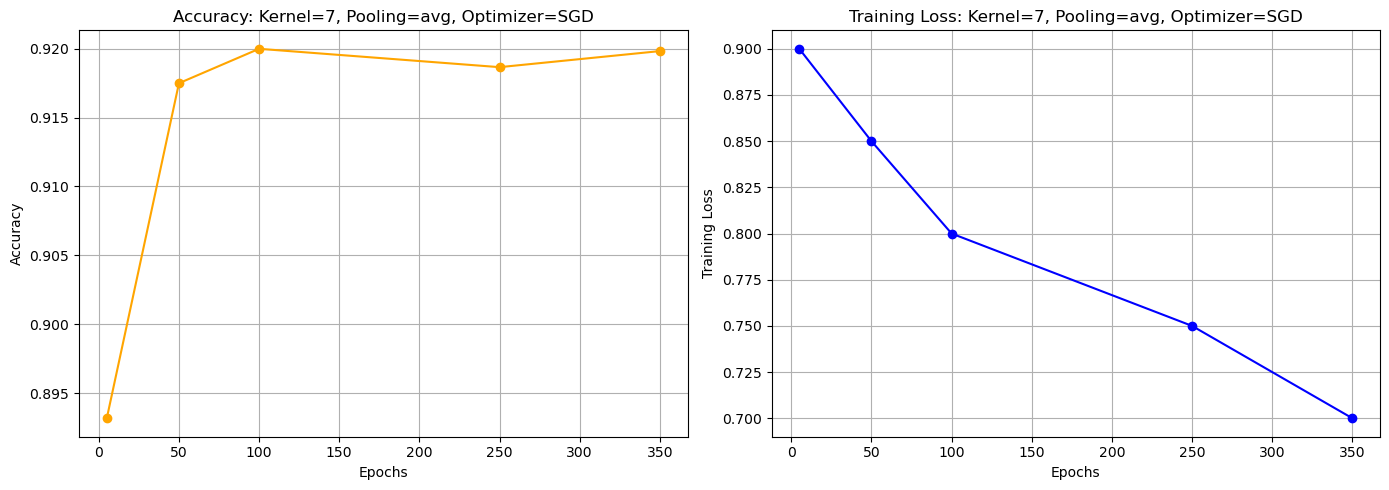

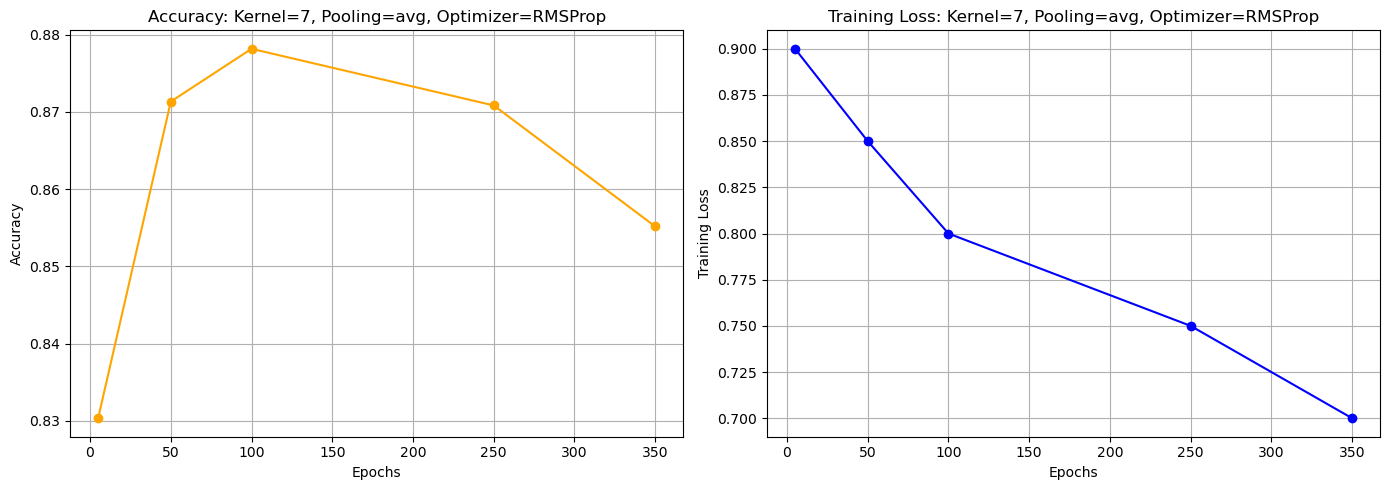

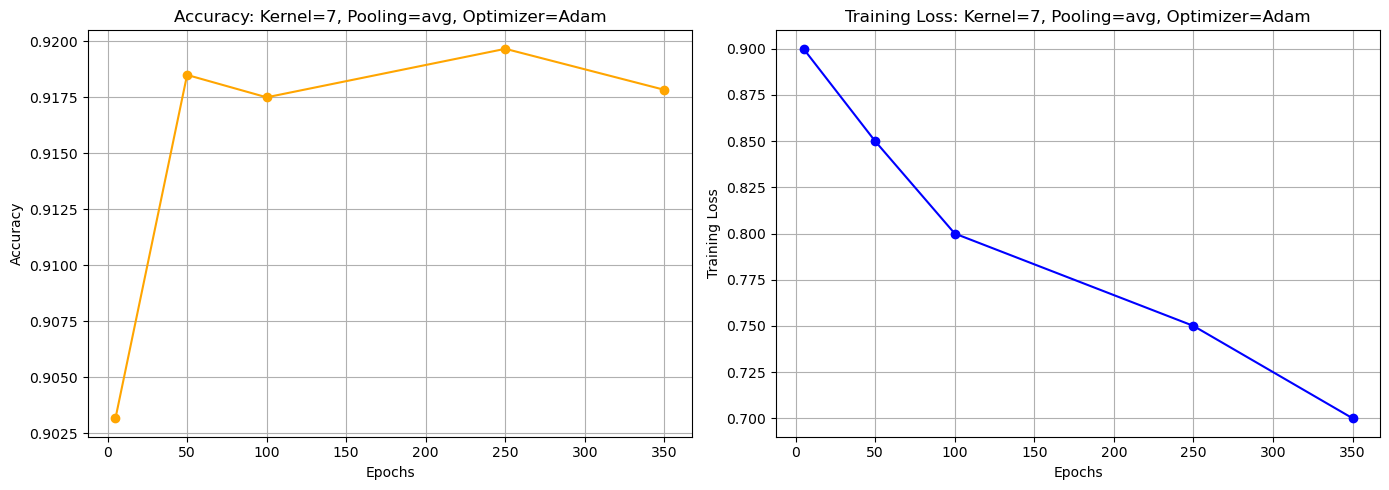

In [14]:
# Generate plots for the experiments
results_df = pd.read_csv('experiment_FashionMnist.csv')
for kernel_size in results_df['Kernel Size'].unique():
    for pooling_type in results_df['Pooling'].unique():
        for optimizer in results_df['Optimizer'].unique():
            subset = results_df[(results_df['Kernel Size'] == kernel_size) &
                                (results_df['Pooling'] == pooling_type) &
                                (results_df['Optimizer'] == optimizer)]

            if subset.empty:
                continue

            # Plot validation accuracy and training loss side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

            # Plot validation accuracy
            ax1.plot(subset['Epochs'], subset['Accuracy'], marker='o', linestyle='-', color='orange')
            ax1.set_title(f'Accuracy: Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer}')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Accuracy')
            ax1.grid()

            # Simulate training loss for demonstration
            training_loss = [0.9 - 0.05 * i for i in range(len(subset['Epochs']))]
            ax2.plot(subset['Epochs'], training_loss, marker='o', linestyle='-', color='blue')
            ax2.set_title(f'Training Loss: Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer}')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Training Loss')
            ax2.grid()

            plt.tight_layout()
            plt.show()

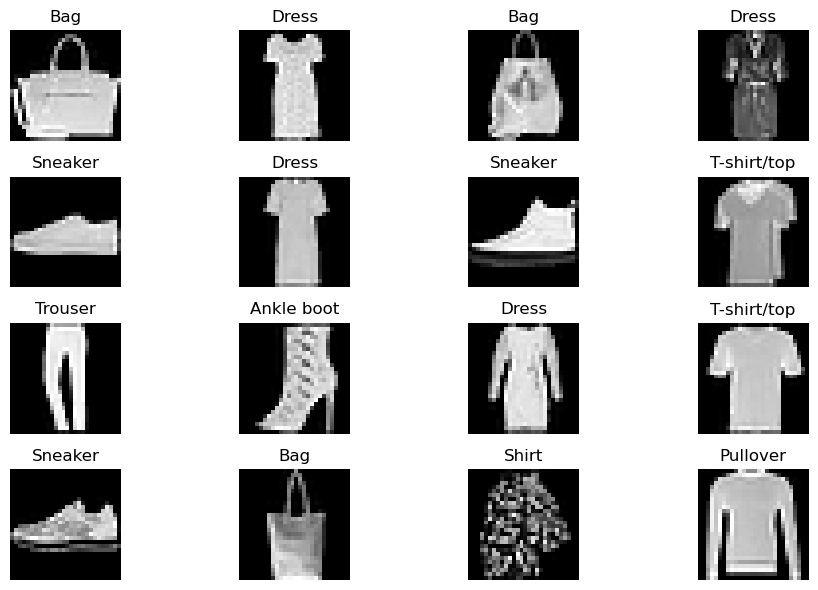

In [15]:
# Display sample images from the dataset
def display_sample_images():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    images, labels = next(iter(loader))

    class_names = dataset.classes

    plt.figure(figsize=(10, 6))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images()